# Scenario X Config -> score training with Random Forest Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

%load_ext autoreload
%autoreload 2

## Load tables and clean data

In [30]:
# Load in data
with open("df_configs_1sector.pl", 'rb') as f:
    config_df = pickle.load(f)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,metric
0,training_0000-S23-P0_1,efficientdet-d5,0.5,eager,sort,0.3,5,1,32.988268,T_mota
1,training_0000-S11-P0_1,efficientdet-d5,0.3,wait,sort,0.3,7,1,15.784484,T_mota
2,training_0000-S5-P0_1,efficientdet-d5,0.5,eager,sort,0.1,3,5,18.213660,T_mota
3,training_0000-S4-P0_1,efficientdet-d3,0.5,wait,sort,0.1,7,5,19.806553,T_mota
4,training_0000-S19-P0_1,efficientdet-d5,0.5,wait,sort,0.2,5,1,69.260065,T_mota
...,...,...,...,...,...,...,...,...,...,...
340987,training_0003-S0-P0_1,efficientdet-d2,0.3,wait,sort,0.2,5,3,21.919392,T_mota
340988,training_0003-S20-P0_1,efficientdet-d6,0.3,wait,sort,0.2,5,1,33.354193,T_mota
340989,training_0002-S8-P0_1,efficientdet-d4,0.3,tail-aware,sort,0.5,5,5,-15.276558,T_mota
340990,training_0002-S17-P0_1,efficientdet-d5,0.3,wait,sort,0.3,5,5,9.857684,T_mota


In [31]:
config_df = config_df[config_df["metric"] == "T_mota"]  # filter by just mota metric
config_df = config_df[config_df["D-seq-pol"] != "infinite"]  # filter out infinite runs
config_df = config_df.drop(columns=["metric"])
config_df["D-conf"] = config_df["D-conf"].astype(float)
config_df["T-min-iou"] = config_df["T-min-iou"].astype(float)
config_df["T-max-age"] = config_df["T-max-age"].astype(int)
config_df["T-every-nth-det"] = config_df["T-every-nth-det"].astype(int)
config_df["score"] = config_df["score"].astype(float)
config_df["run"] = config_df["run"].apply(lambda x: x.replace("-P0_1", ""))
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0000-S23,efficientdet-d5,0.5,eager,sort,0.3,5,1,32.988268
1,training_0000-S11,efficientdet-d5,0.3,wait,sort,0.3,7,1,15.784484
2,training_0000-S5,efficientdet-d5,0.5,eager,sort,0.1,3,5,18.213660
3,training_0000-S4,efficientdet-d3,0.5,wait,sort,0.1,7,5,19.806553
4,training_0000-S19,efficientdet-d5,0.5,wait,sort,0.2,5,1,69.260065
...,...,...,...,...,...,...,...,...,...
340987,training_0003-S0,efficientdet-d2,0.3,wait,sort,0.2,5,3,21.919392
340988,training_0003-S20,efficientdet-d6,0.3,wait,sort,0.2,5,1,33.354193
340989,training_0002-S8,efficientdet-d4,0.3,tail-aware,sort,0.5,5,5,-15.276558
340990,training_0002-S17,efficientdet-d5,0.3,wait,sort,0.3,5,5,9.857684


In [35]:
scenario_feats_df = pd.read_csv("../data/scenario_features_v2.csv")
scenario_feats_df

,Unnamed: 0,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,weather,location,scenario_name
0,0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,sunny,location_sf,training_0004-S_24
1,1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,sunny,location_sf,training_0004-S_14
2,2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,sunny,location_phx,training_0004-S_0
3,3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,sunny,location_phx,training_0004-S_23
4,4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,sunny,location_sf,training_0004-S_13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,sunny,location_sf,training_0001-S_15
144,144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,sunny,location_phx,training_0001-S_5
145,145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,sunny,location_phx,training_0001-S_22
146,146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,sunny,location_phx,training_0001-S_12


In [36]:
scenario_feats_df = scenario_feats_df.drop(columns=["Unnamed: 0"])
scenario_feats_df = scenario_feats_df.drop(columns=["weather"])  # weather column is all the same
# scenario_feats_df = scenario_feats_df.drop(columns=["time_of_day"])  # removing feature for fun
# scenario_feats_df = scenario_feats_df.drop(columns=["location"])  # removing feature for fun
scenario_feats_df["scenario_name"] = scenario_feats_df["scenario_name"].apply(lambda x: x.replace("-S_", "-S"))
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,53.444444,80.2,6.0,247.234697,8954.720055,2.417085,101.993745,3410.922277,8.827853,Day,location_sf,training_0004-S24
1,117.961538,197.0,20.0,131.738267,38093.553801,15.568528,60.189865,24916.815591,1.613907,Day,location_sf,training_0004-S14
2,64.694444,156.0,25.0,51.889146,8095.026669,11.703518,28.880993,3753.227900,18.223584,Day,location_phx,training_0004-S0
3,45.413043,67.0,21.0,107.360995,4593.823205,10.550505,72.368302,2318.215522,12.334894,Day,location_phx,training_0004-S23
4,121.321429,197.0,73.0,28.401004,12588.225953,68.974619,12.779036,10279.801052,1.585742,Day,location_sf,training_0004-S13
...,...,...,...,...,...,...,...,...,...,...,...,...
143,30.791667,54.7,8.0,472.672033,155746.596694,3.713568,170.250245,60098.840417,2.458020,Day,location_sf,training_0001-S15
144,150.954545,199.0,20.0,31.987256,6475.869405,16.688442,19.789628,3907.838562,5.888482,Day,location_phx,training_0001-S5
145,66.637363,165.0,40.2,52.452393,8235.238310,30.472362,35.758511,6157.662639,28.623804,Day,location_phx,training_0001-S22
146,83.633333,159.3,18.0,67.911989,13281.949758,12.671717,42.263428,7677.699864,10.682600,Day,location_phx,training_0001-S12


### Join tables, one-hot encode

In [37]:
joined_df = config_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df")
assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location
training_0000-S0,efficientdet-d5,0.5,eager,sort,0.3,5,1,36.385199,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.3,tail-aware,sort,0.2,5,1,46.110057,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.5,wait,sort,0.3,5,3,15.607211,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.3,tail-aware,sort,0.2,3,1,47.722960,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
training_0000-S0,efficientdet-d5,0.3,eager,sort,0.5,1,3,-0.901328,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,Day,location_sf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9,efficientdet-d7,0.3,tail-aware,sort,0.5,3,5,-3.230171,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d1,0.5,wait,sort,0.5,7,5,-4.928751,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d4,0.3,eager,sort,0.1,7,5,23.151718,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx
training_0005-S9,efficientdet-d7x,0.5,wait,sort,0.2,1,3,21.816337,92.553846,166.0,39.0,68.574074,6813.796370,30.383838,33.839843,3812.852294,7.269207,Day,location_phx


In [38]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df

,D-conf,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,...,D-seq-pol__eager,D-seq-pol__tail-aware,D-seq-pol__wait,T-model__sort,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf
training_0000-S0,0.5,0.3,5,1,36.385199,85.080000,169.8,14.0,95.804566,34172.474092,...,1,0,0,1,0,1,0,0,0,1
training_0000-S0,0.3,0.2,5,1,46.110057,85.080000,169.8,14.0,95.804566,34172.474092,...,0,1,0,1,0,1,0,0,0,1
training_0000-S0,0.5,0.3,5,3,15.607211,85.080000,169.8,14.0,95.804566,34172.474092,...,0,0,1,1,0,1,0,0,0,1
training_0000-S0,0.3,0.2,3,1,47.722960,85.080000,169.8,14.0,95.804566,34172.474092,...,0,1,0,1,0,1,0,0,0,1
training_0000-S0,0.3,0.5,1,3,-0.901328,85.080000,169.8,14.0,95.804566,34172.474092,...,1,0,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9,0.3,0.5,3,5,-3.230171,92.553846,166.0,39.0,68.574074,6813.796370,...,0,1,0,1,0,1,0,0,1,0
training_0005-S9,0.5,0.5,7,5,-4.928751,92.553846,166.0,39.0,68.574074,6813.796370,...,0,0,1,1,0,1,0,0,1,0
training_0005-S9,0.3,0.1,7,5,23.151718,92.553846,166.0,39.0,68.574074,6813.796370,...,1,0,0,1,0,1,0,0,1,0
training_0005-S9,0.5,0.2,1,3,21.816337,92.553846,166.0,39.0,68.574074,6813.796370,...,0,0,1,1,0,1,0,0,1,0


## Prep training

In [40]:
# Extract the labels
labels = np.array(joined_df.pop('score'))

### Scenario examples are fairly balanced, so we just do train-test and cross-v splits across scenario boundaries

/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/ges/miniconda3/envs/erdos_env/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='Density'>

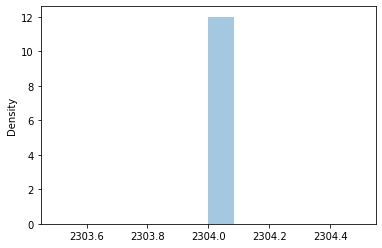

In [41]:
counts = joined_df.index.value_counts()
sns.distplot(counts)

#### Manual train-test split across scenario boundaries

In [42]:
import random
unique_scenarios = list(joined_df.index.unique())
unique_scenarios = sorted(unique_scenarios)
random.shuffle(unique_scenarios, random=lambda: 0.43)
train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df.index.isin(train_scenarios)], labels[joined_df.index.isin(train_scenarios)]
test, test_labels = joined_df[joined_df.index.isin(test_scenarios)], labels[joined_df.index.isin(test_scenarios)]

In [43]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

In [44]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['D-conf',
  'T-min-iou',
  'T-max-age',
  'T-every-nth-det',
  'avg_bbox_longevity',
  '90p_bbox_longevity',
  '90p_num_bboxes',
  '90p_bbox_speed',
  '90p_bbox_size',
  'avg_num_bboxes',
  'avg_bbox_speed',
  'avg_bbox_size',
  'avg_ego_speed',
  'D-model__efficientdet-d1',
  'D-model__efficientdet-d2',
  'D-model__efficientdet-d3',
  'D-model__efficientdet-d4',
  'D-model__efficientdet-d5',
  'D-model__efficientdet-d6',
  'D-model__efficientdet-d7',
  'D-model__efficientdet-d7x',
  'D-seq-pol__eager',
  'D-seq-pol__tail-aware',
  'D-seq-pol__wait',
  'T-model__sort',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf'],
 31)

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [45]:
# Made raw text to allow running from top

In [46]:
from scipy.stats import loguniform, randint

In [47]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [48]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6669.,  983.,  589.,  406.,  314.,  274.,  225.,  209.,  164.,
         167.]),
 array([0.00010005, 0.01008869, 0.02007732, 0.03006595, 0.04005458,
        0.05004321, 0.06003184, 0.07002047, 0.0800091 , 0.08999773,
        0.09998637]),
 <BarContainer object of 10 artists>)

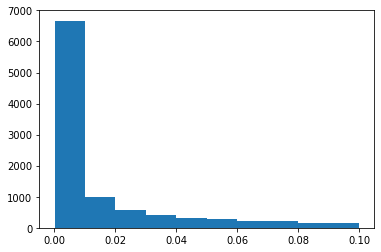

In [49]:
import matplotlib.pyplot as plt
plt.hist(x)

In [50]:
# 2:52pm start

In [51]:
from ad_config_search.rforest_utils import ScenarioAwareCVSplitter  # splits validation dataset across scenario boundaries
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 25),
    "max_features": randint(1, 24),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2)
}, cv=ScenarioAwareCVSplitter(n_splits=5, shuffle=True, random_state=RSEED), n_iter=100)
clf.fit(train, train_labels)

<class 'pandas.core.frame.DataFrame'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   22.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.6s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    0.9s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elap

RandomizedSearchCV(cv=<ad_config_search.rforest_utils.ScenarioAwareCVSplitter object at 0x7f3a54ad2f28>,
                   estimator=RandomForestRegressor(max_depth=16, max_features=6,
                                                   min_impurity_decrease=0.00015375064885708676,
                                                   n_estimators=200, n_jobs=-1,
                                                   random_state=50, verbose=1),
                   n_iter=100,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3a54ad27b8>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3a54ad2908>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3a54ad2c50>,
                                        'n_estimators': [200, 400, 800, 1600,
                                                         2

In [54]:
clf.cv_results_

{'mean_fit_time': array([16.58902259,  1.28252964,  2.77311234,  3.25242481,  6.17434382,
         1.44663692,  5.59376597,  6.5323782 ,  2.92686424, 14.91232667,
         5.02708101,  5.49946365,  6.47068605,  3.58383541,  6.19006433,
         2.41203022,  5.08048358,  6.7570817 , 17.75395398,  5.13009701,
        11.52988744, 17.30562959,  3.68887267, 14.29059615, 14.07193007,
         7.4027967 ,  1.47464962,  2.30127721,  7.20459037,  1.17003751,
         9.01257305,  1.25530958, 16.19389715,  1.73640151,  2.39455385,
         5.18385434,  1.31754398,  9.85713458,  5.90839763,  5.48306484,
         7.62285228,  6.92970033,  3.39647622, 20.49829116,  5.56672359,
         3.30219417, 16.04682503,  9.66452274,  2.07611275,  5.14727716,
         4.09341984,  7.04952884, 11.40008993,  2.03234129,  2.35633678,
        11.73058143, 16.19757233, 12.03866739,  2.33616929, 10.0073843 ,
        11.70613379,  1.51407208,  6.86554151,  1.27550917,  1.83199983,
         8.94748535,  4.94643226, 

In [53]:
clf.best_estimator_

RandomForestRegressor(max_depth=19, max_features=4,
                      min_impurity_decrease=0.00017857402731668312,
                      n_estimators=2400, n_jobs=-1, random_state=50, verbose=1)

## Training

In [56]:
# Create the model with 100 trees
model = RandomForestRegressor(max_depth=19, max_features=4,
                      min_impurity_decrease=0.00017857402731668312,
                      n_estimators=2400,
                              random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 962 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:   20.2s finished


RandomForestRegressor(max_depth=19, max_features=4,
                      min_impurity_decrease=0.00017857402731668312,
                      n_estimators=2400, n_jobs=-1, random_state=50, verbose=1)

In [57]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('90p_bbox_size', 0.16731969074179698),
 ('avg_bbox_size', 0.11382745954266706),
 ('avg_num_bboxes', 0.09624989238843396),
 ('90p_bbox_longevity', 0.07689113167456652),
 ('avg_ego_speed', 0.07003564545722755),
 ('90p_num_bboxes', 0.06905949703715057),
 ('avg_bbox_longevity', 0.06829425479062552),
 ('T-min-iou', 0.06639611190219791),
 ('90p_bbox_speed', 0.053479344569343126),
 ('avg_bbox_speed', 0.044634795504303985),
 ('D-model__efficientdet-d7x', 0.024383027648260818),
 ('D-model__efficientdet-d2', 0.022291100844552606),
 ('D-model__efficientdet-d1', 0.01906996731760409),
 ('T-every-nth-det', 0.01811171776991694),
 ('D-model__efficientdet-d7', 0.01647908207688605),
 ('T-max-age', 0.015398878142865726),
 ('location__location_other', 0.012750457560154952),
 ('location__location_sf', 0.012321251645576523),
 ('location__location_phx', 0.006810268833335948),
 ('D-model__efficientdet-d6', 0.005708493781563679),
 ('D-model__efficientdet-d4', 0.0051462068058130105),
 ('D-model__efficientdet-

In [58]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 12770
Average maximum depth 19


In [59]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
print("train score", model.score(train, train_labels))

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
test_score = model.score(test, test_labels)
print("test score", test_score)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.3s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.9s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.4s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    2.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.9s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.4s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    2.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.


train score 0.9803555570187226


[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.7s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.0s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    1.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.3s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.8s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.1s


test score 0.5442578207792887


[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    1.6s finished


In [60]:
model_type = "RF"
env_window = "200"
time = "present"
env_feats = "gt-v2"
dictionary = {
    "model": model,
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "test_labels": test_labels
}
with open("model={}__env-window={}__time={}__env-feats={}__te={:.2f}.pl".format(model_type, env_window, time, env_feats, test_score), 'wb') as f:
    pickle.dump(dictionary, f)

## Using trained model to get best config and saving

In [61]:
train_copy = train.copy()
test_copy = test.copy()

In [62]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.9s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.4s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    2.2s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 962 tasks      | elapsed:    0.7s
[Parallel(n_jobs=144)]: Done 1512 tasks      | elapsed:    1.0s
[Parallel(n_jobs=144)]: Done 2400 out of 2400 | elapsed:    1.6s finished


In [64]:
train.index.unique()

Index(['training_0000-S7', 'training_0000-S8', 'training_0000-S9',
       'training_0001-S0', 'training_0001-S1', 'training_0001-S10',
       'training_0001-S11', 'training_0001-S12', 'training_0001-S13',
       'training_0001-S14', 'training_0001-S15', 'training_0001-S16',
       'training_0001-S17', 'training_0001-S18', 'training_0001-S19',
       'training_0001-S2', 'training_0001-S20', 'training_0001-S21',
       'training_0001-S22', 'training_0001-S23', 'training_0001-S3',
       'training_0001-S4', 'training_0001-S5', 'training_0001-S6',
       'training_0001-S7', 'training_0001-S8', 'training_0001-S9',
       'training_0002-S0', 'training_0002-S1', 'training_0002-S10',
       'training_0002-S11', 'training_0002-S12', 'training_0002-S13',
       'training_0002-S14', 'training_0002-S15', 'training_0002-S16',
       'training_0002-S17', 'training_0002-S18', 'training_0002-S19',
       'training_0002-S2', 'training_0002-S20', 'training_0002-S21',
       'training_0002-S22', 'trainin

In [65]:
test.index.unique()

Index(['training_0000-S0', 'training_0000-S1', 'training_0000-S10',
       'training_0000-S11', 'training_0000-S12', 'training_0000-S13',
       'training_0000-S14', 'training_0000-S15', 'training_0000-S16',
       'training_0000-S17', 'training_0000-S18', 'training_0000-S19',
       'training_0000-S2', 'training_0000-S20', 'training_0000-S21',
       'training_0000-S22', 'training_0000-S23', 'training_0000-S3',
       'training_0000-S4', 'training_0000-S5', 'training_0000-S6',
       'training_0002-S24', 'training_0002-S4', 'training_0002-S6',
       'training_0002-S9', 'training_0003-S1', 'training_0003-S11',
       'training_0003-S14', 'training_0003-S16', 'training_0003-S18',
       'training_0003-S20', 'training_0003-S22', 'training_0003-S24',
       'training_0003-S5', 'training_0003-S7', 'training_0003-S9',
       'training_0004-S1', 'training_0004-S12', 'training_0004-S14',
       'training_0004-S16', 'training_0004-S19', 'training_0004-S20',
       'training_0004-S22', 'traini

In [66]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [67]:
to_predict = test_copy

In [68]:
best_predicted_configs = pd.DataFrame([rows.iloc[rows["prediction"].argmax()] for run_name, rows in to_predict.groupby(["run_name"])])

In [69]:
from ad_config_search.utils import contract_one_hot

In [70]:
best_predicted_configs = contract_one_hot(best_predicted_configs)

In [71]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,prediction,run_name,T-model,D-seq-pol,location,D-model,time_of_day
training_0000-S0,0.5,0.1,1,1,85.080000,169.8,14.0,95.804566,34172.474092,10.742424,56.625234,23269.829340,5.588190,45.712521,training_0000-S0,sort,tail-aware,location_sf,efficientdet-d4,Day
training_0000-S1,0.3,0.1,3,1,103.259259,175.0,50.0,49.616457,46870.875085,42.030151,30.518480,52875.208306,0.383722,33.293975,training_0000-S1,sort,wait,location_sf,efficientdet-d7x,Day
training_0000-S10,0.5,0.1,3,1,56.454545,105.0,4.0,76.439390,38357.517547,3.120603,41.192411,17850.350271,4.144654,45.700786,training_0000-S10,sort,wait,location_sf,efficientdet-d4,Dawn/Dusk
training_0000-S11,0.3,0.1,3,1,53.425000,99.6,38.0,41.488826,2842.560143,32.378788,33.613229,2000.154715,19.094199,13.635643,training_0000-S11,sort,tail-aware,location_phx,efficientdet-d4,Day
training_0000-S12,0.3,0.1,3,1,45.666667,126.0,8.0,185.012790,26528.361155,4.843434,69.958587,8737.199796,8.112840,32.211283,training_0000-S12,sort,eager,location_phx,efficientdet-d4,Night
training_0000-S13,0.5,0.1,5,1,65.357143,192.6,43.3,25.798442,55747.348700,23.106061,17.399413,38025.392681,1.142726,33.920364,training_0000-S13,sort,tail-aware,location_sf,efficientdet-d7x,Dawn/Dusk
training_0000-S14,0.5,0.1,3,1,103.153846,198.0,46.0,26.803467,8849.946543,33.863636,16.176909,6910.080792,2.374864,26.360298,training_0000-S14,sort,tail-aware,location_phx,efficientdet-d7x,Day
training_0000-S15,0.3,0.1,3,1,76.118421,192.5,33.0,76.705012,18219.508422,29.217172,49.077779,12410.133293,4.609326,33.770009,training_0000-S15,sort,tail-aware,location_sf,efficientdet-d6,Night
training_0000-S16,0.3,0.1,5,1,82.721649,194.4,52.2,44.823852,18010.665024,40.321608,26.818691,13557.233961,6.141586,29.322451,training_0000-S16,sort,eager,location_sf,efficientdet-d7x,Day
training_0000-S17,0.5,0.1,1,1,42.065868,100.0,55.0,240.021246,10265.541383,35.301508,102.823789,7670.240834,6.222526,21.099937,training_0000-S17,sort,eager,location_sf,efficientdet-d4,Day


In [72]:
RF_policy_map = {}
for index, row in best_predicted_configs.iterrows():
    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"]
    RF_policy_map[index] = {c: row[c] for c in config_columns}

In [74]:
import pickle
with open("RF_test_policy_map_v2.pl", 'wb') as f:
    pickle.dump(RF_policy_map, f)